# Going Bottom-up approach now

In [3]:
%matplotlib inline
from fastai import *

Whatever we did in lesson-2, where we studied SGD, now we're gonna build a neural network for the MNIST dataset (grab it from http://deeplearning.net/data/mnist/mnist.pkl.gz)

In [2]:
man wget

In [4]:
path = Path('data/mnist')

In [4]:
path.mkdir(parents = True, exist_ok = True)

In [5]:
!wget http://deeplearning.net/data/mnist/mnist.pkl.gz -P {path}

--2018-12-06 10:53:39--  http://deeplearning.net/data/mnist/mnist.pkl.gz
Resolving deeplearning.net (deeplearning.net)... 132.204.26.28
Connecting to deeplearning.net (deeplearning.net)|132.204.26.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16168813 (15M) [application/x-gzip]
Saving to: ‘data/mnist/mnist.pkl.gz’

mnist.pkl.gz        100%[===================>]  15.42M  13.6MB/s    in 1.1s    

2018-12-06 10:53:40 (13.6 MB/s) - ‘data/mnist/mnist.pkl.gz’ saved [16168813/16168813]



In [5]:
with gzip.open(path/'mnist.pkl.gz', mode = 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding = 'latin-1')

In [7]:
f

<gzip on 0x7f1819fac6d8>

In [8]:
x_train.shape

(50000, 784)

In [9]:
y_train.shape

(50000,)

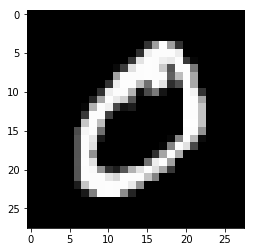

In [11]:
plt.imshow(x_train[1].reshape((28,28)), cmap = 'gray')

In [6]:
x_train, y_train, x_valid, y_valid = map(torch.tensor, (x_train, y_train, x_valid, y_valid))

# Map the normal numpy arrays into tensors by using the above function from pyTorch

In [16]:
x_train

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [20]:
x_train.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9))

Now in Lesson-2, we had hand-coded the SGD functions. We'll take the help of Pytorch now to implement SGD

In [21]:
TensorDataset??

We can make a custom simple dataset using the above pytorch function. Note that TensorDataset takes tensors as input

In [8]:
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)

In [25]:
DataBunch.create??

In [9]:
bs = 64

In [10]:
data = DataBunch.create(train_ds, valid_ds, bs = bs)

In [11]:
x, y = next(iter(data.train_dl))

In [35]:
x.shape, y.shape

(torch.Size([64, 784]), torch.Size([64]))

Now we'll create a Logistic regression neural network using the nn module of pytorch

In [12]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10, bias = True) # Applies a linear transformation to the input data
    
    def forward(self, xb) : return self.lin(xb)
        
# Since we're making our own neural network class, we need to call the super's init to build the framework

        

In [13]:
model = Mnist_Logistic().cuda()

In [39]:
model

Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [40]:
model(x).shape

torch.Size([64, 10])

In [14]:
[p.shape for p in model.parameters()]

[torch.Size([10, 784]), torch.Size([10])]

In [15]:
lr = 2e-2

In [16]:
loss_fn = nn.CrossEntropyLoss()

In [17]:
def update_params(x, y, lr):
    wd = 1e-5 # Weight decay constant
    y_hat = model(x)
    # Adding L2 regularization (weight decay)
    w2 = 0.
    for p in model.parameters():
        w2 += (p**2).sum()
    
    loss = loss_fn(y_hat, y) + w2*wd
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad) # sub_ makes subtraction in-place
            p.grad.zero_()
    return loss.item()

In [18]:
losses = [update_params(x, y, lr) for x, y in data.train_dl]

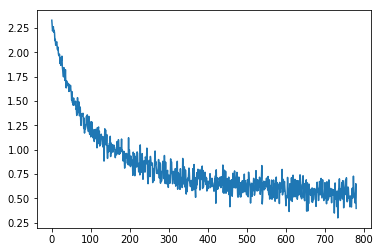

In [19]:
plt.plot(losses)

Observing the above plot, we see that since we used a constant learning rate, as our losses are decreasing and the model is getting more optimal, the losses are fluctuating up and down some more. This solidifies our understanding that we need to decrease the learning rate as the losses decrease

Now we'll add a hidden layer here. 

In [20]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias = True)
        self.lin2 = nn.Linear(50, 10, bias = True)
        
    def forward(self, xb):
        x = self.lin1(xb)
        x = F.relu(x)
        return self.lin2(x)

In [21]:
model = Mnist_NN().cuda()

In [22]:
losses = [update_params(x, y, lr) for x, y in data.train_dl]

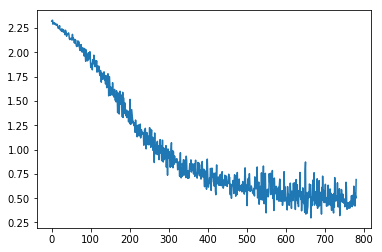

In [23]:
plt.plot(losses)

Now we'll optimize our code a little bit

In [25]:
model = Mnist_NN().cuda()

In [26]:
def update_params(x, y, lr):
    opt = optim.SGD(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_fn(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [27]:
losses = [update_params(x, y , lr) for x, y in data.train_dl]

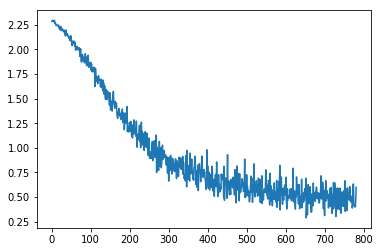

In [28]:
plt.plot(losses)

Note that this is the same curve as we got for the previous curve

Now we'll use an optimizer (Adam)

In [35]:
def update_params(x, y, lr):
    opt = optim.Adam(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_fn(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [31]:
losses = [update_params(x, y , lr) for x, y in data.train_dl]

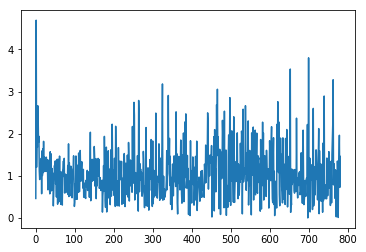

In [32]:
plt.plot(losses)

We see that the learning rate is too high and so the plot is jumping up and down. Since we're using an optimizer, we'll decrease the learning rate

In [38]:
model = Mnist_NN().cuda()

losses = [update_params(x, y , 1e-3) for x, y in data.train_dl]

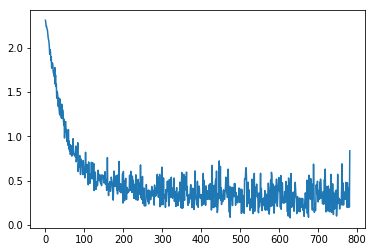

In [39]:
plt.plot(losses)

In [40]:
learn = Learner(data, Mnist_NN(), loss_func = loss_fn, metrics = accuracy)

In [41]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


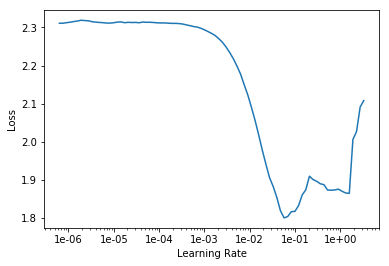

In [42]:
learn.recorder.plot()

In [43]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy
1,0.133550,0.131344,0.962200


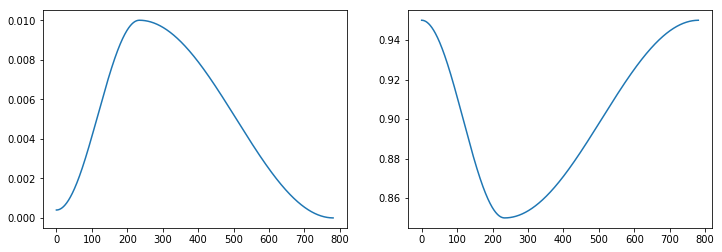

In [44]:
learn.recorder.plot_lr(show_moms = True)

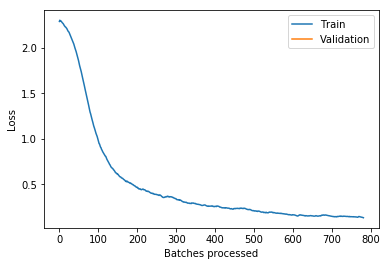

In [45]:
learn.recorder.plot_losses()